In [1]:
import os
import mne
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mne.time_frequency import psd_array_multitaper

from shared.helper_functions import save_figure, select_folder, select_or_create_folder
from settings_general import freq_bands_eeg, low_qual_chans, subject_id_batch_cage_dict

Change plot theme

In [2]:
sns.set_theme()

Define palettes

In [3]:
palette = {'DRD2-WT': '#427C99', 'DRD2-KO': '#AF5541'}
palette_gr = {'DRD2-WT':'#6A8D73', 'DRD2-KO':'#984447'}
palette_gr_lighter = {'DRD2-WT':'#AEC2B3', 'DRD2-KO':'#C68083'}

Select the folder holding the epoch files we need and a plot output folder

In [4]:
epoch_folder = select_folder("Select the folder that holds the direct social interaction experiment's epoch files")
plot_folder = select_or_create_folder("Create or select a folder the plots will be saved to")

2024-05-14 10:11:03.609 python[30160:1368770] +[CATransaction synchronize] called within transaction
2024-05-14 10:11:13.191 python[30160:1368770] +[CATransaction synchronize] called within transaction


 ## Analysis of one subject
Load the epochs of a test subject

In [5]:
subject_id = 78233
epochs = mne.read_epochs(os.path.join(epoch_folder, f"epochs_{subject_id}-epo.fif"), preload=True)
len(epochs)

28

Let's define the channels we wish to investigate

In [6]:
wanted_chans = [chan for chan in epochs.info['ch_names'] if chan not in ['EMG_L', 'EMG_R']]
wanted_chans

['OFC_R', 'OFC_L', 'CG', 'STR_R', 'S1_L', 'S1_R', 'V1_R']

In [7]:
print(f'There are {len(epochs)} epochs for subject {subject_id}')
print(f'{len(epochs[epochs.metadata["event_kind"] == "sniff"])} are sniffing epochs')
print(f'{len(epochs[epochs.metadata["event_kind"] == "groom"])} are grooming epochs')
print(f'{len(epochs[epochs.metadata["event_kind"] == "follow"])} are grooming epochs')

There are 28 epochs for subject 78233
22 are sniffing epochs
2 are grooming epochs
4 are grooming epochs


The Epoch Array metadata contains further information on how the epochs were created. Let's take a look.

In [36]:
epochs.metadata.head()

subject_id genotype  event_n  event_part_n event_kind  total_event_duration  \
0      78233  DRD2-WT        2             1      sniff                 1.635   
1      78233  DRD2-WT        4             1      sniff                 1.266   
2      78233  DRD2-WT        5             1      sniff                 2.000   
3      78233  DRD2-WT        5             2      sniff                 2.000   
4      78233  DRD2-WT        6             1      sniff                 0.233   

   epoch_length  
0           1.0  
1           1.0  
2           1.0  
3           1.0  
4           1.0

The metadata contains the interaction identifier. So all rows where *interaction_n* == 1 is data of one single event, with in this case is a sniff event.

The *interaction_part_n* tells you something about where along the total interaction duration that specific epoch is located.

Let's take the first interaction as an example. We can see, an interaction of 2.033 seconds yielded 3 epochs of 1 seconds.

### Define power -> decibel calculation function

In [8]:
def nanpow2db(y):
    """ Power to dB conversion, setting bad values to nans
        Arguments:
            y (float or array-like): power
        Returns:
            ydB (float or np array): inputs converted to dB with 0s and negatives resulting in nans
    """

    if isinstance(y, int) or isinstance(y, float):
        if y == 0:
            return np.nan
        else:
            ydB = 10 * np.log10(y)
    else:
        if isinstance(y, list):  # if list, turn into array
            y = np.asarray(y)
        y = y.astype(float)  # make sure it's a float array so we can put nans in it
        y[y == 0] = np.nan
        ydB = 10 * np.log10(y)

    return ydB

### Plot the individual epoch powers

In [38]:
psds_sub_sniff, freqs = psd_array_multitaper(
    epochs[epochs.metadata.event_kind == 'sniff'].get_data(picks="STR_R"),
    fmin=0, fmax=100,
    sfreq=epochs.info['sfreq'],
    n_jobs=-1,
    verbose='WARNING'
)
psds_sub_groom, freqs = psd_array_multitaper(
    epochs[epochs.metadata.event_kind == 'groom'].get_data(picks="STR_R"),
    fmin=0, fmax=100,
    sfreq=epochs.info['sfreq'],
    n_jobs=-1,
    verbose='WARNING'
)
psds_sub_follow, freqs = psd_array_multitaper(
    epochs[epochs.metadata.event_kind == 'follow'].get_data(picks="STR_R"),
    fmin=0, fmax=100,
    sfreq=epochs.info['sfreq'],
    n_jobs=-1,
    verbose='WARNING'
)

In [39]:
fig = plt.figure(figsize=(10, 6))

for i in range(psds_sub_sniff.shape[0]):
    sns.lineplot(x=freqs, y=psds_sub_sniff[i, 0, :], alpha=0.4, linewidth=.3, color='green')

for i in range(psds_sub_follow.shape[0]):
    sns.lineplot(x=freqs, y=psds_sub_follow[i, 0, :], alpha=0.4, linewidth=.3, color='blue')

for i in range(psds_sub_groom.shape[0]):
    sns.lineplot(x=freqs, y=psds_sub_groom[i, 0, :], alpha=0.4, linewidth=.3, color='red')

plt.yscale('log')
plt.show()

ValueError: Data has no positive values, and therefore cannot be log-scaled.

<Figure size 1000x600 with 1 Axes>

### Power Spectral Density (PSD) calculation for the one subject

In [40]:
df = pd.DataFrame()

for event_type in epochs.metadata.event_kind.unique():

    subject_data = epochs[epochs.metadata["event_kind"] == event_type]
    subject_id = subject_data.metadata["subject_id"].iloc[0]
    genotype = subject_data.metadata["genotype"].iloc[0]

    for channel in wanted_chans:
        # skip plotting data of bad quality
        if int(subject_id) in low_qual_chans.keys():
            if channel in low_qual_chans[int(subject_id)]:
                print(f"Omitting channel {channel} for subject {subject_id}.")
                continue

        # get the average PSD for this subject
        psds_sub, freqs = psd_array_multitaper(
            subject_data.get_data(picks=channel),
            fmin=0, fmax=100,
            sfreq=subject_data.info['sfreq'],
            n_jobs=-1,
            verbose='WARNING'
        )
        total_power = np.sum(psds_sub, axis=-1)
        psds_sub_norm = psds_sub / total_power[:, np.newaxis]

        mean_psd_sub = np.mean(psds_sub[:, 0, :], axis=0)
        mean_psd_sub_norm = np.mean(psds_sub_norm[:, 0, :], axis=0)

        # save the average of this subject, so we can later plot the mean of the subject averages
        df = pd.concat([df, pd.DataFrame({
            "freq": freqs,
            "psd (means)": mean_psd_sub,
            "psd (norm)": mean_psd_sub_norm,
            "subject_id": subject_id,
            "genotype": genotype,
            "channel": channel,
            "event_type": event_type,
        })])

Let's inspect it a bit

In [41]:
df.head()

freq  psd (means)  psd (norm) subject_id genotype channel event_type
0   0.0          NaN         NaN      78233  DRD2-WT   OFC_R      sniff
1   1.0          NaN         NaN      78233  DRD2-WT   OFC_R      sniff
2   2.0          NaN         NaN      78233  DRD2-WT   OFC_R      sniff
3   3.0          NaN         NaN      78233  DRD2-WT   OFC_R      sniff
4   4.0          NaN         NaN      78233  DRD2-WT   OFC_R      sniff

And now we plot the distinct event powers for all channels. As we're only looking at one subject, we cannot yet compare genotype differences

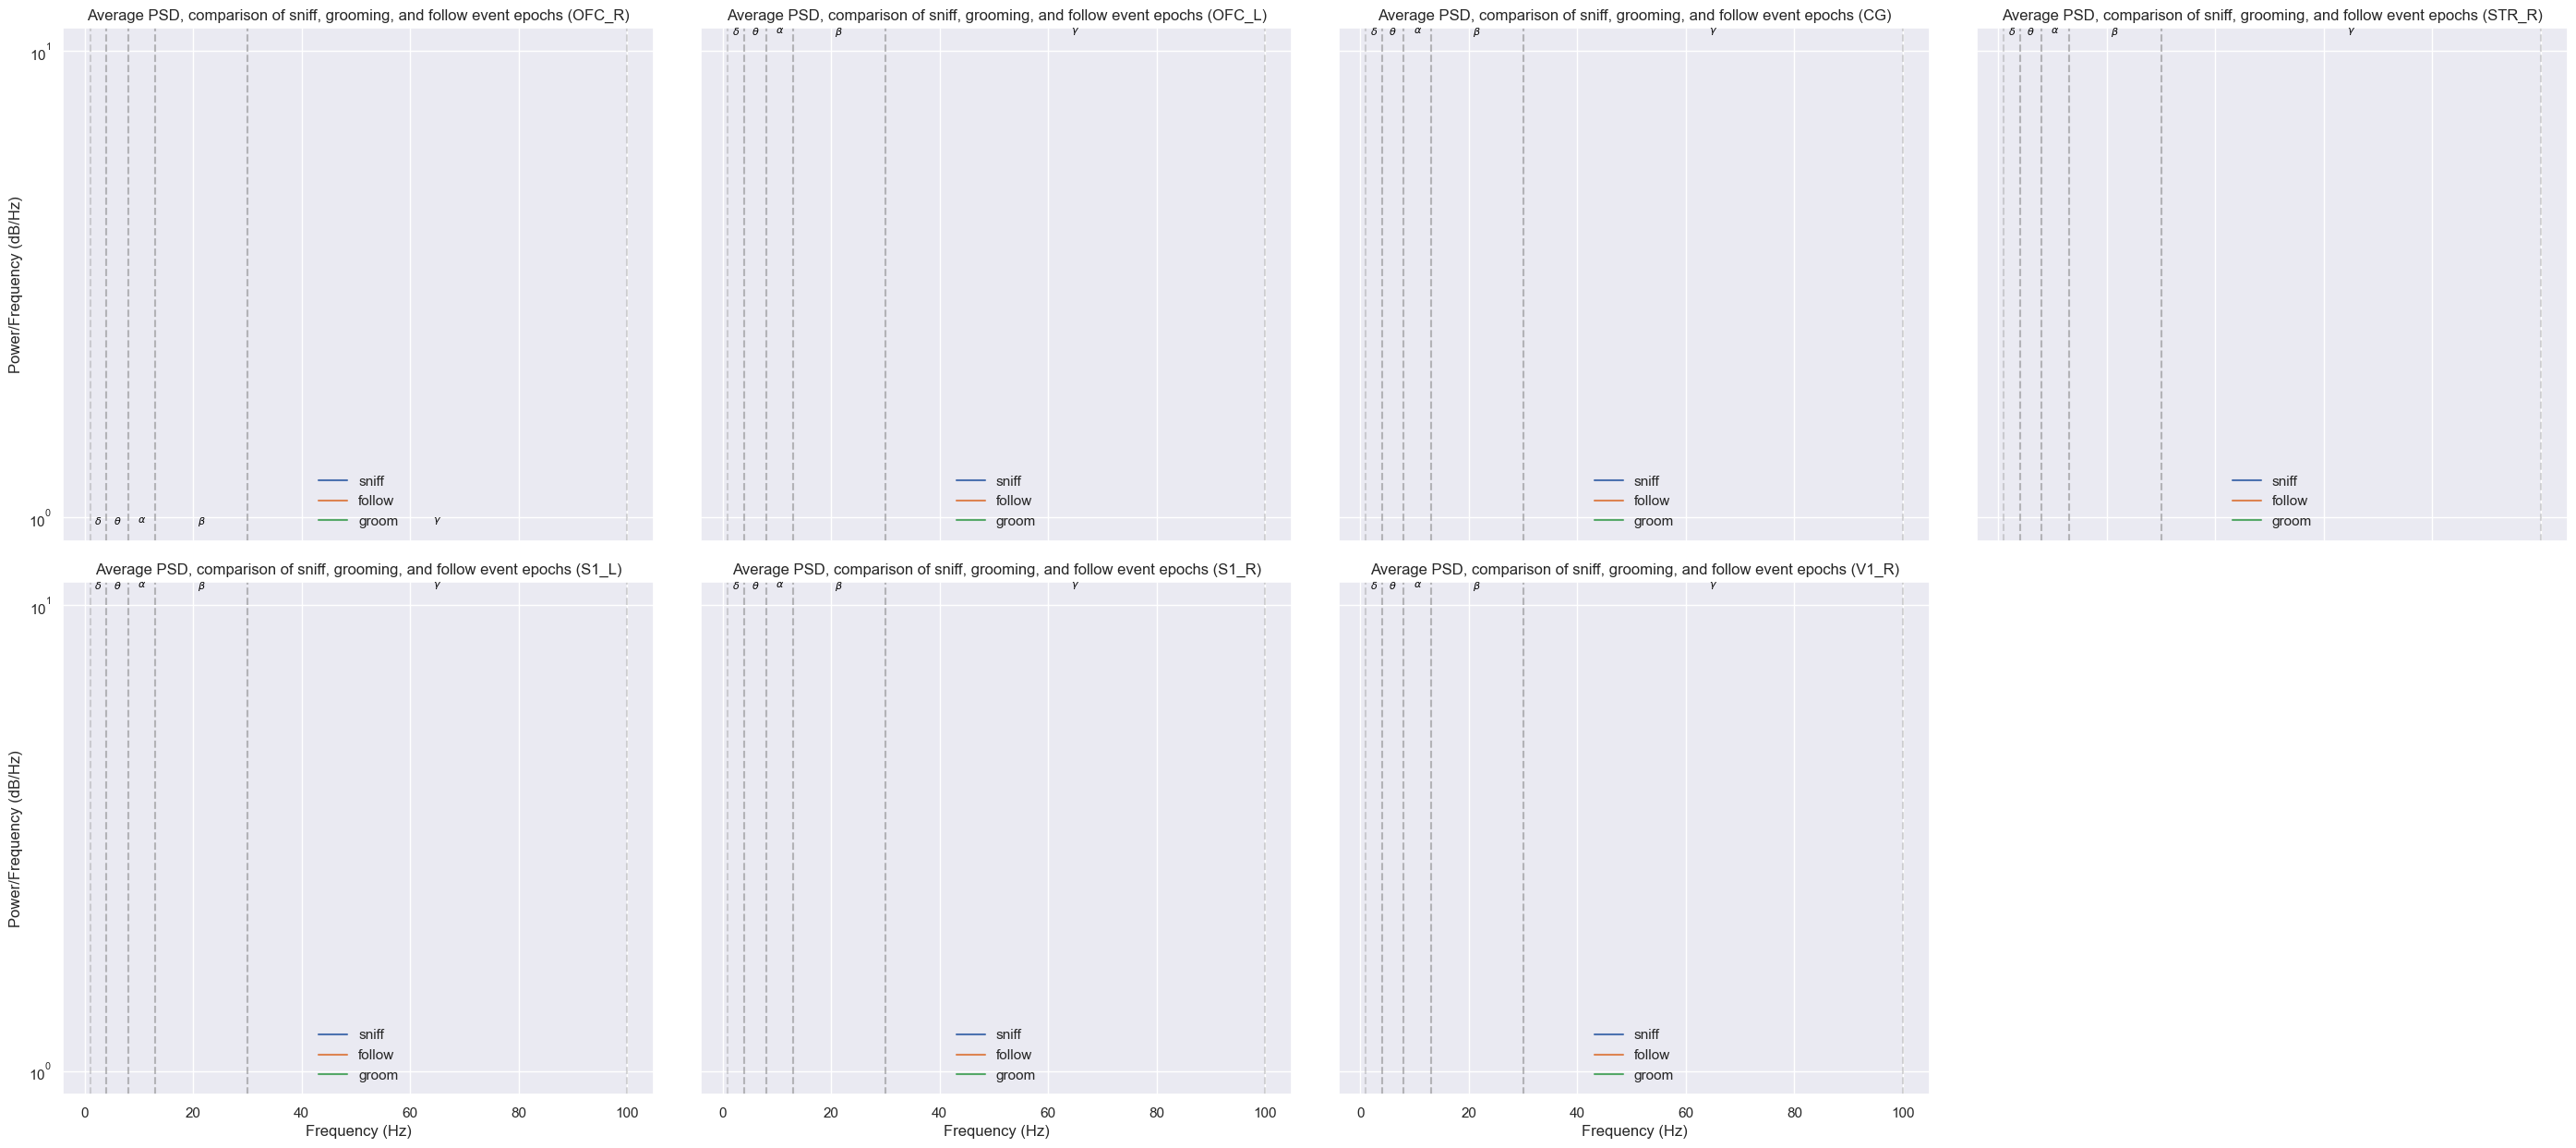

In [42]:
fig, axs = plt.subplots(2, 4, figsize=(35, 15), sharex=True, sharey=True)
axs = axs.ravel()

for i, channel in enumerate(wanted_chans):

    channel_data = df[df.channel == channel]
    channel_data = channel_data[(channel_data.freq > 52) | (channel_data.freq < 48)]  # remove the 50Hz peak

    sns.lineplot(data=channel_data, x='freq', y='psd (norm)', hue="event_type", legend=True, ax=axs[i], errorbar=('ci', 95))

    for band, (start, end) in freq_bands_eeg.items():
        axs[i].axvline(x=start, color='gray', linestyle='--', alpha=0.3)
        axs[i].axvline(x=end, color='gray', linestyle='--', alpha=0.3)
        axs[i].text((start + end) / 2, axs[i].get_ylim()[1] * 1.01, band, horizontalalignment='center', verticalalignment='top', fontsize=8, color='black')

    axs[i].set_yscale('log')
    axs[i].set_xlabel('Frequency (Hz)')
    axs[i].set_ylabel('Power/Frequency (dB/Hz)')
    axs[i].set_title(f'Average PSD, comparison of sniff, grooming, and follow event epochs ({channel})')
    axs[i].legend(frameon=False, loc='best')

plt.subplots_adjust(wspace=0.08, hspace=0.08)
axs[-1].remove()
plt.show()

## Analysis of all subjects

First we load all the epoch files

In [9]:
all_subject_epochs = []
for file in os.listdir(epoch_folder):
    if not file.endswith('.fif'):
        continue
    all_subject_epochs.append(mne.read_epochs(os.path.join(epoch_folder, file), preload=True, verbose='WARNING'))

In [10]:
len(all_subject_epochs)

19

First, let's calculate how many epochs of each kind of event there are in total

In [12]:
total_epochs = {}

for subject_epochs in all_subject_epochs:
    for event_type in subject_epochs.metadata.event_kind.unique():
        if not event_type in total_epochs.keys():
            total_epochs[event_type] = len(subject_epochs[subject_epochs.metadata["event_kind"] == event_type])
        else:
            total_epochs[event_type] = total_epochs[event_type] + len(subject_epochs[subject_epochs.metadata["event_kind"] == event_type])
total_epochs

{'sniff': 423, 'follow': 123, 'groom': 47}

Let's calculate the PSDs again, but now for all animals

In [39]:
df = pd.DataFrame()

for subject_epochs in all_subject_epochs:

    subject_id = subject_epochs.metadata["subject_id"].iloc[0]
    genotype = subject_epochs.metadata["genotype"].iloc[0]

    for event_type in subject_epochs.metadata.event_kind.unique():

        subject_data = subject_epochs[subject_epochs.metadata["event_kind"] == event_type]

        for channel in wanted_chans:
            # skip plotting data of bad quality
            if int(subject_id) in low_qual_chans.keys():
                if channel in low_qual_chans[int(subject_id)]:
                    print(f"Omitting channel {channel} for subject {subject_id}.")
                    continue

            # get the average PSD for this subject
            psds_sub, freqs = psd_array_multitaper(
                subject_data.get_data(picks=channel),
                fmin=0, fmax=100,
                sfreq=subject_data.info['sfreq'],
                n_jobs=-1,
                verbose='WARNING'
            )
            decibels = nanpow2db(psds_sub)

            # normalize the decibels
            total_power = np.abs(np.sum(decibels, axis=-1))
            decibels_norm = decibels / total_power[:, np.newaxis]

            mean_decibels = np.mean(decibels[:, 0, :], axis=0)
            mean_decibels_norm = np.mean(decibels_norm[:, 0, :], axis=0)

            # normalize the raw psds
            total_power = np.sum(psds_sub, axis=-1)
            psds_sub_norm = psds_sub / total_power[:, np.newaxis]

            # average the powers of all epochs
            mean_psd_sub = np.mean(psds_sub[:, 0, :], axis=0)
            mean_psd_sub_norm = np.mean(psds_sub_norm[:, 0, :], axis=0)

            # save the average of this subject, so we can later plot the mean of the subject averages
            df = pd.concat([df, pd.DataFrame({
                "freq": freqs,
                "psd (means)": mean_psd_sub,
                "psd (norm)": mean_psd_sub_norm,
                "decibels": mean_decibels,
                "decibels (norm)": mean_decibels_norm,
                "subject_id": subject_id,
                "genotype": genotype,
                "channel": channel,
                "event_type": event_type,
            })])

    print(f"Done with subject {subject_id}.")

Omitting channel OFC_L for subject 80625.
Omitting channel OFC_L for subject 80625.
Done with subject 80625.
Done with subject 80108.
Done with subject 81175.
Omitting channel OFC_R for subject 39489.
Omitting channel OFC_R for subject 39489.
Done with subject 39489.
Done with subject 79604.
Done with subject 81218.
Done with subject 78233.
Omitting channel OFC_R for subject 81193.
Omitting channel OFC_L for subject 81193.
Omitting channel OFC_R for subject 81193.
Omitting channel OFC_L for subject 81193.
Omitting channel OFC_R for subject 81193.
Omitting channel OFC_L for subject 81193.
Done with subject 81193.
Done with subject 78244.
Done with subject 79592.
Done with subject 79593.
Done with subject 78211.
Done with subject 78227.
Done with subject 81217.
Done with subject 81207.
Done with subject 80630.
Done with subject 80620.
Done with subject 39508.
Done with subject 79602.


Let's check if the dataframe contains what we think it does: all subjects, two types of interactions and the genotypes

In [40]:
print(f'Unique subjects: {df.subject_id.unique()} (n={len(df.subject_id.unique())})')
print(f'The genotypes: {np.unique([df[df.subject_id == subject_id].genotype.iloc[0] for subject_id in df.subject_id.unique()], return_counts=True)}')
print(f'Unique interactions: {df.event_type.unique()}')

Unique subjects: ['80625' '80108' '81175' '39489' '79604' '81218' '78233' '81193' '78244'
 '79592' '79593' '78211' '78227' '81217' '81207' '80630' '80620' '39508'
 '79602'] (n=19)
The genotypes: (array(['DRD2-KO', 'DRD2-WT'], dtype='<U7'), array([10,  9]))
Unique interactions: ['sniff' 'follow' 'groom']


So there are 10 KOs and 9 WTs

First, let's make an overview grid plot of each subjects PSDs per channel

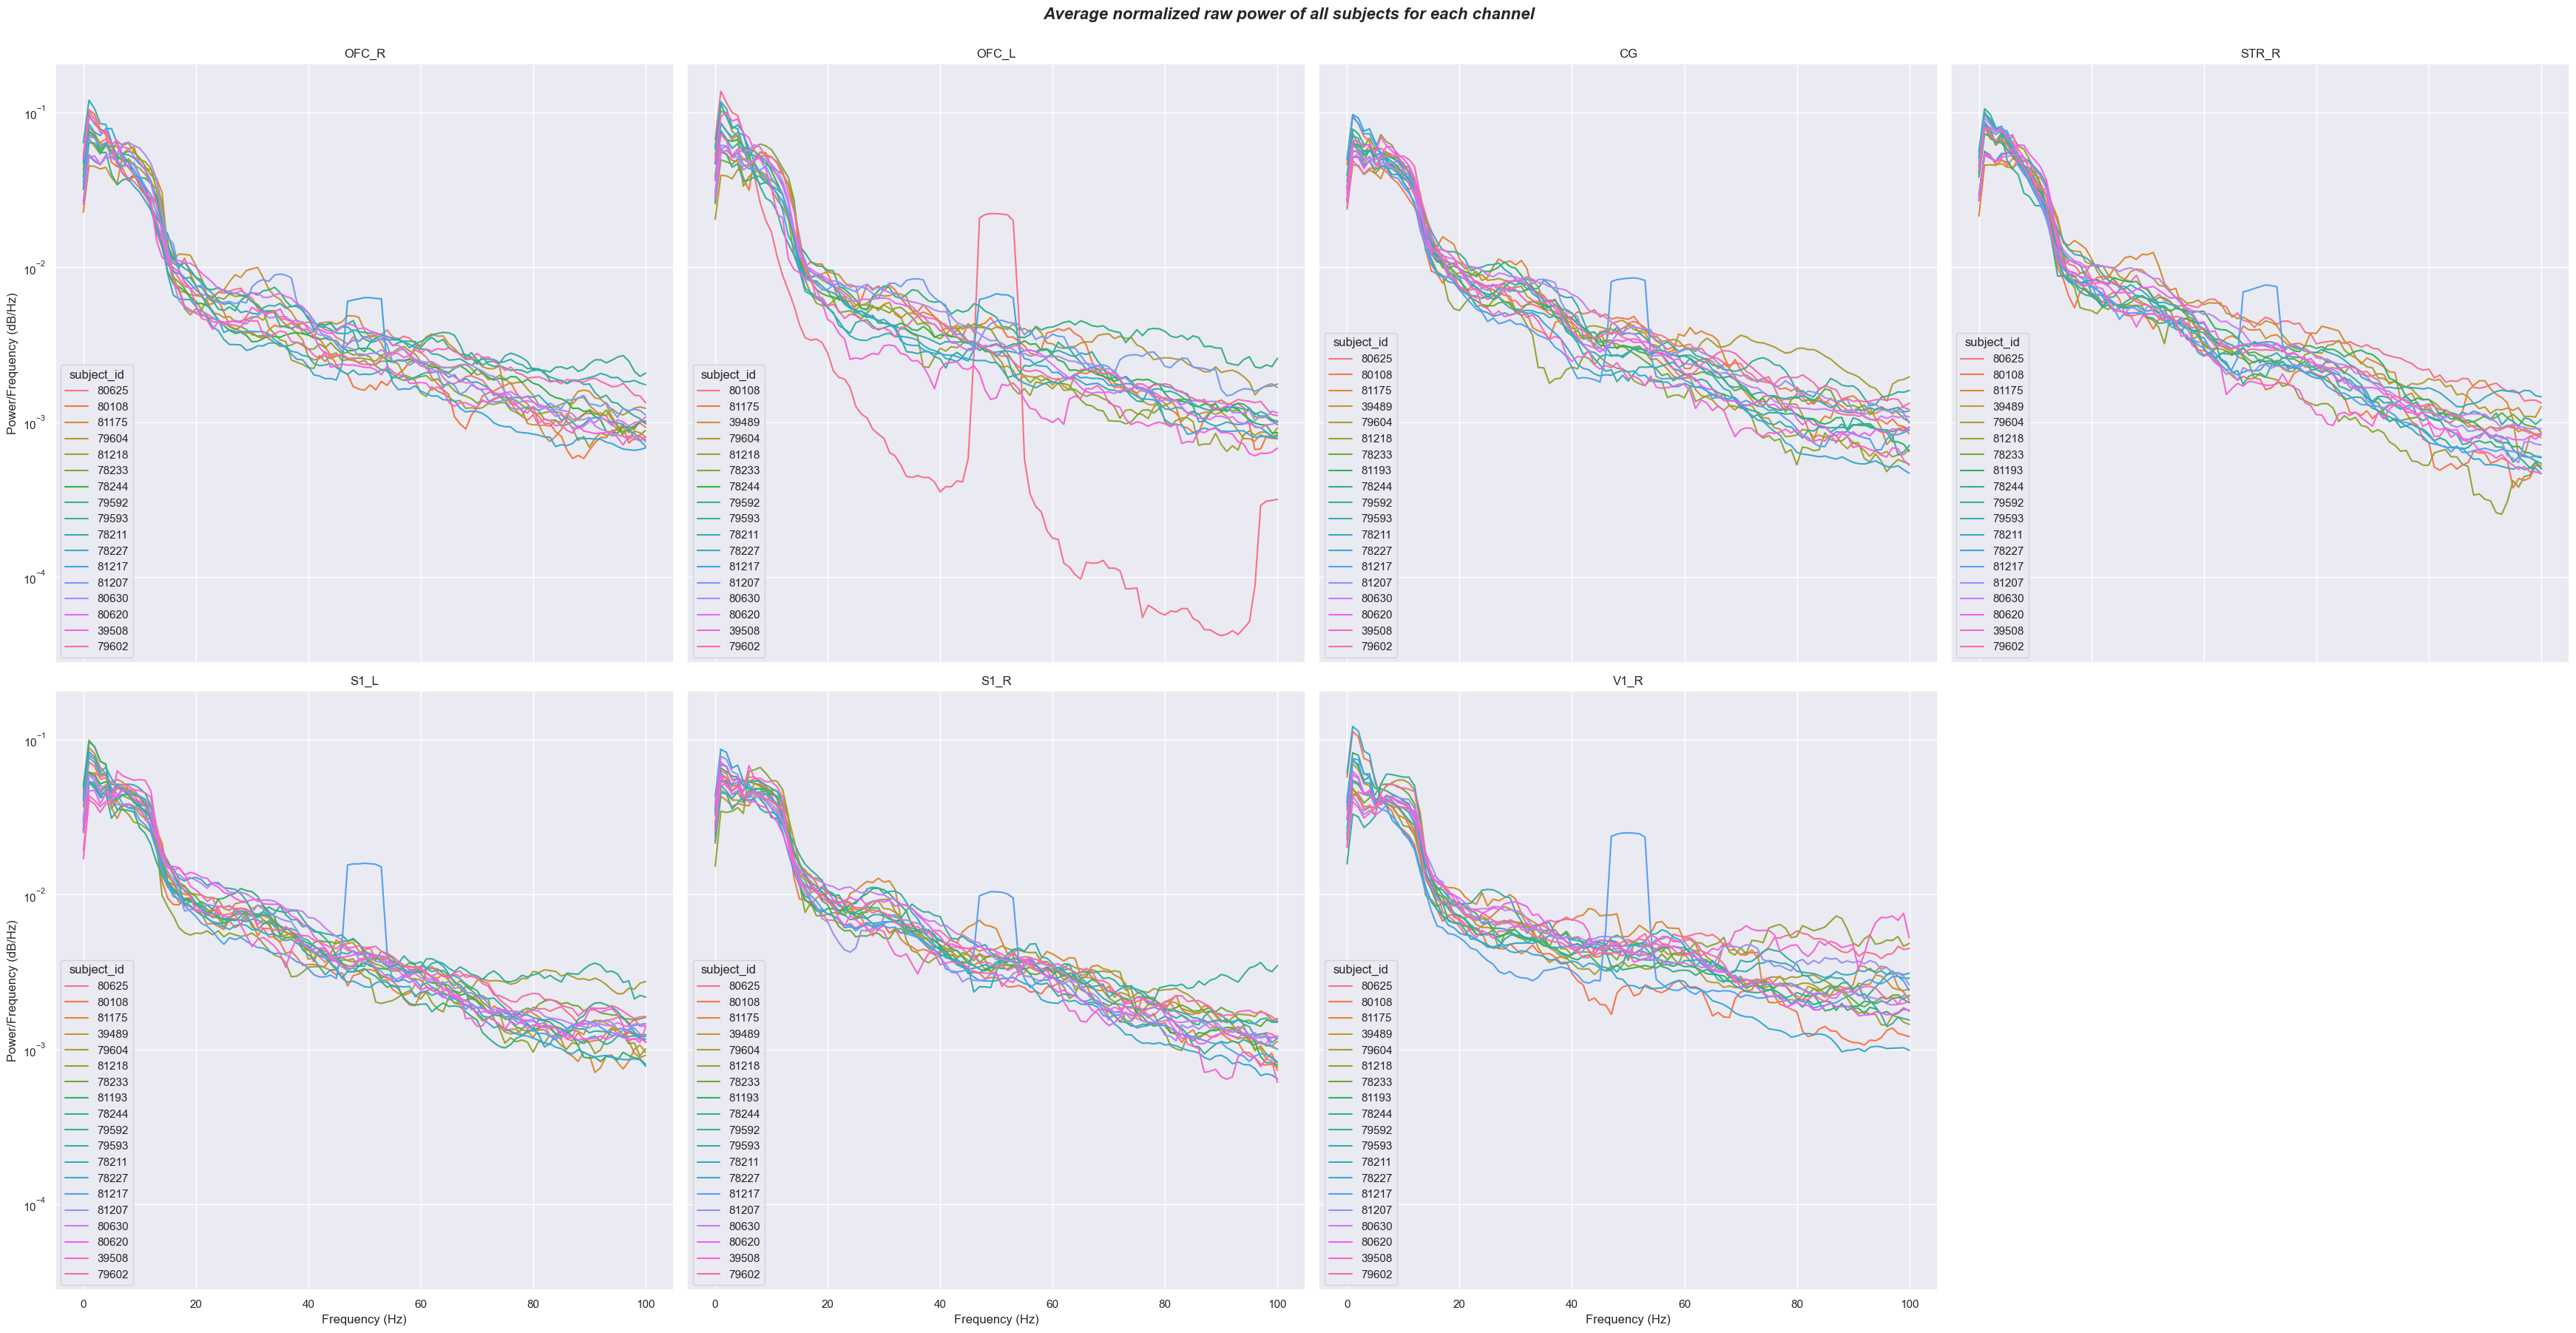

In [16]:
fig, axs = plt.subplots(2, 4, figsize=(35, 18), sharex=True, sharey=True)
axs = axs.ravel()

for i, channel in enumerate(wanted_chans):

    channel_data = df[df.channel == channel]

    sns.lineplot(channel_data, y='psd (norm)', x='freq', hue='subject_id', ax=axs[i], errorbar=None)

    axs[i].set_yscale('log')
    axs[i].set_xlabel('Frequency (Hz)')
    axs[i].set_ylabel('Power/Frequency (dB/Hz)')
    axs[i].set_title(channel)

plt.suptitle(
    'Average normalized raw power of all subjects for each channel',
    fontsize=16, fontweight='bold', fontstyle='italic', y=1
)
plt.tight_layout()
axs[-1].remove()
plt.show()

Remove the unwanted subjects using the code below by pasting the subject id(s) in there

In [41]:
df = df[~df.subject_id.isin(['80108'])]
df.subject_id.unique()

array(['80625', '81175', '39489', '79604', '81218', '78233', '81193',
       '78244', '79592', '79593', '78211', '78227', '81217', '81207',
       '80630', '80620', '39508', '79602'], dtype=object)

Now that low quality subjects are removed, plot again

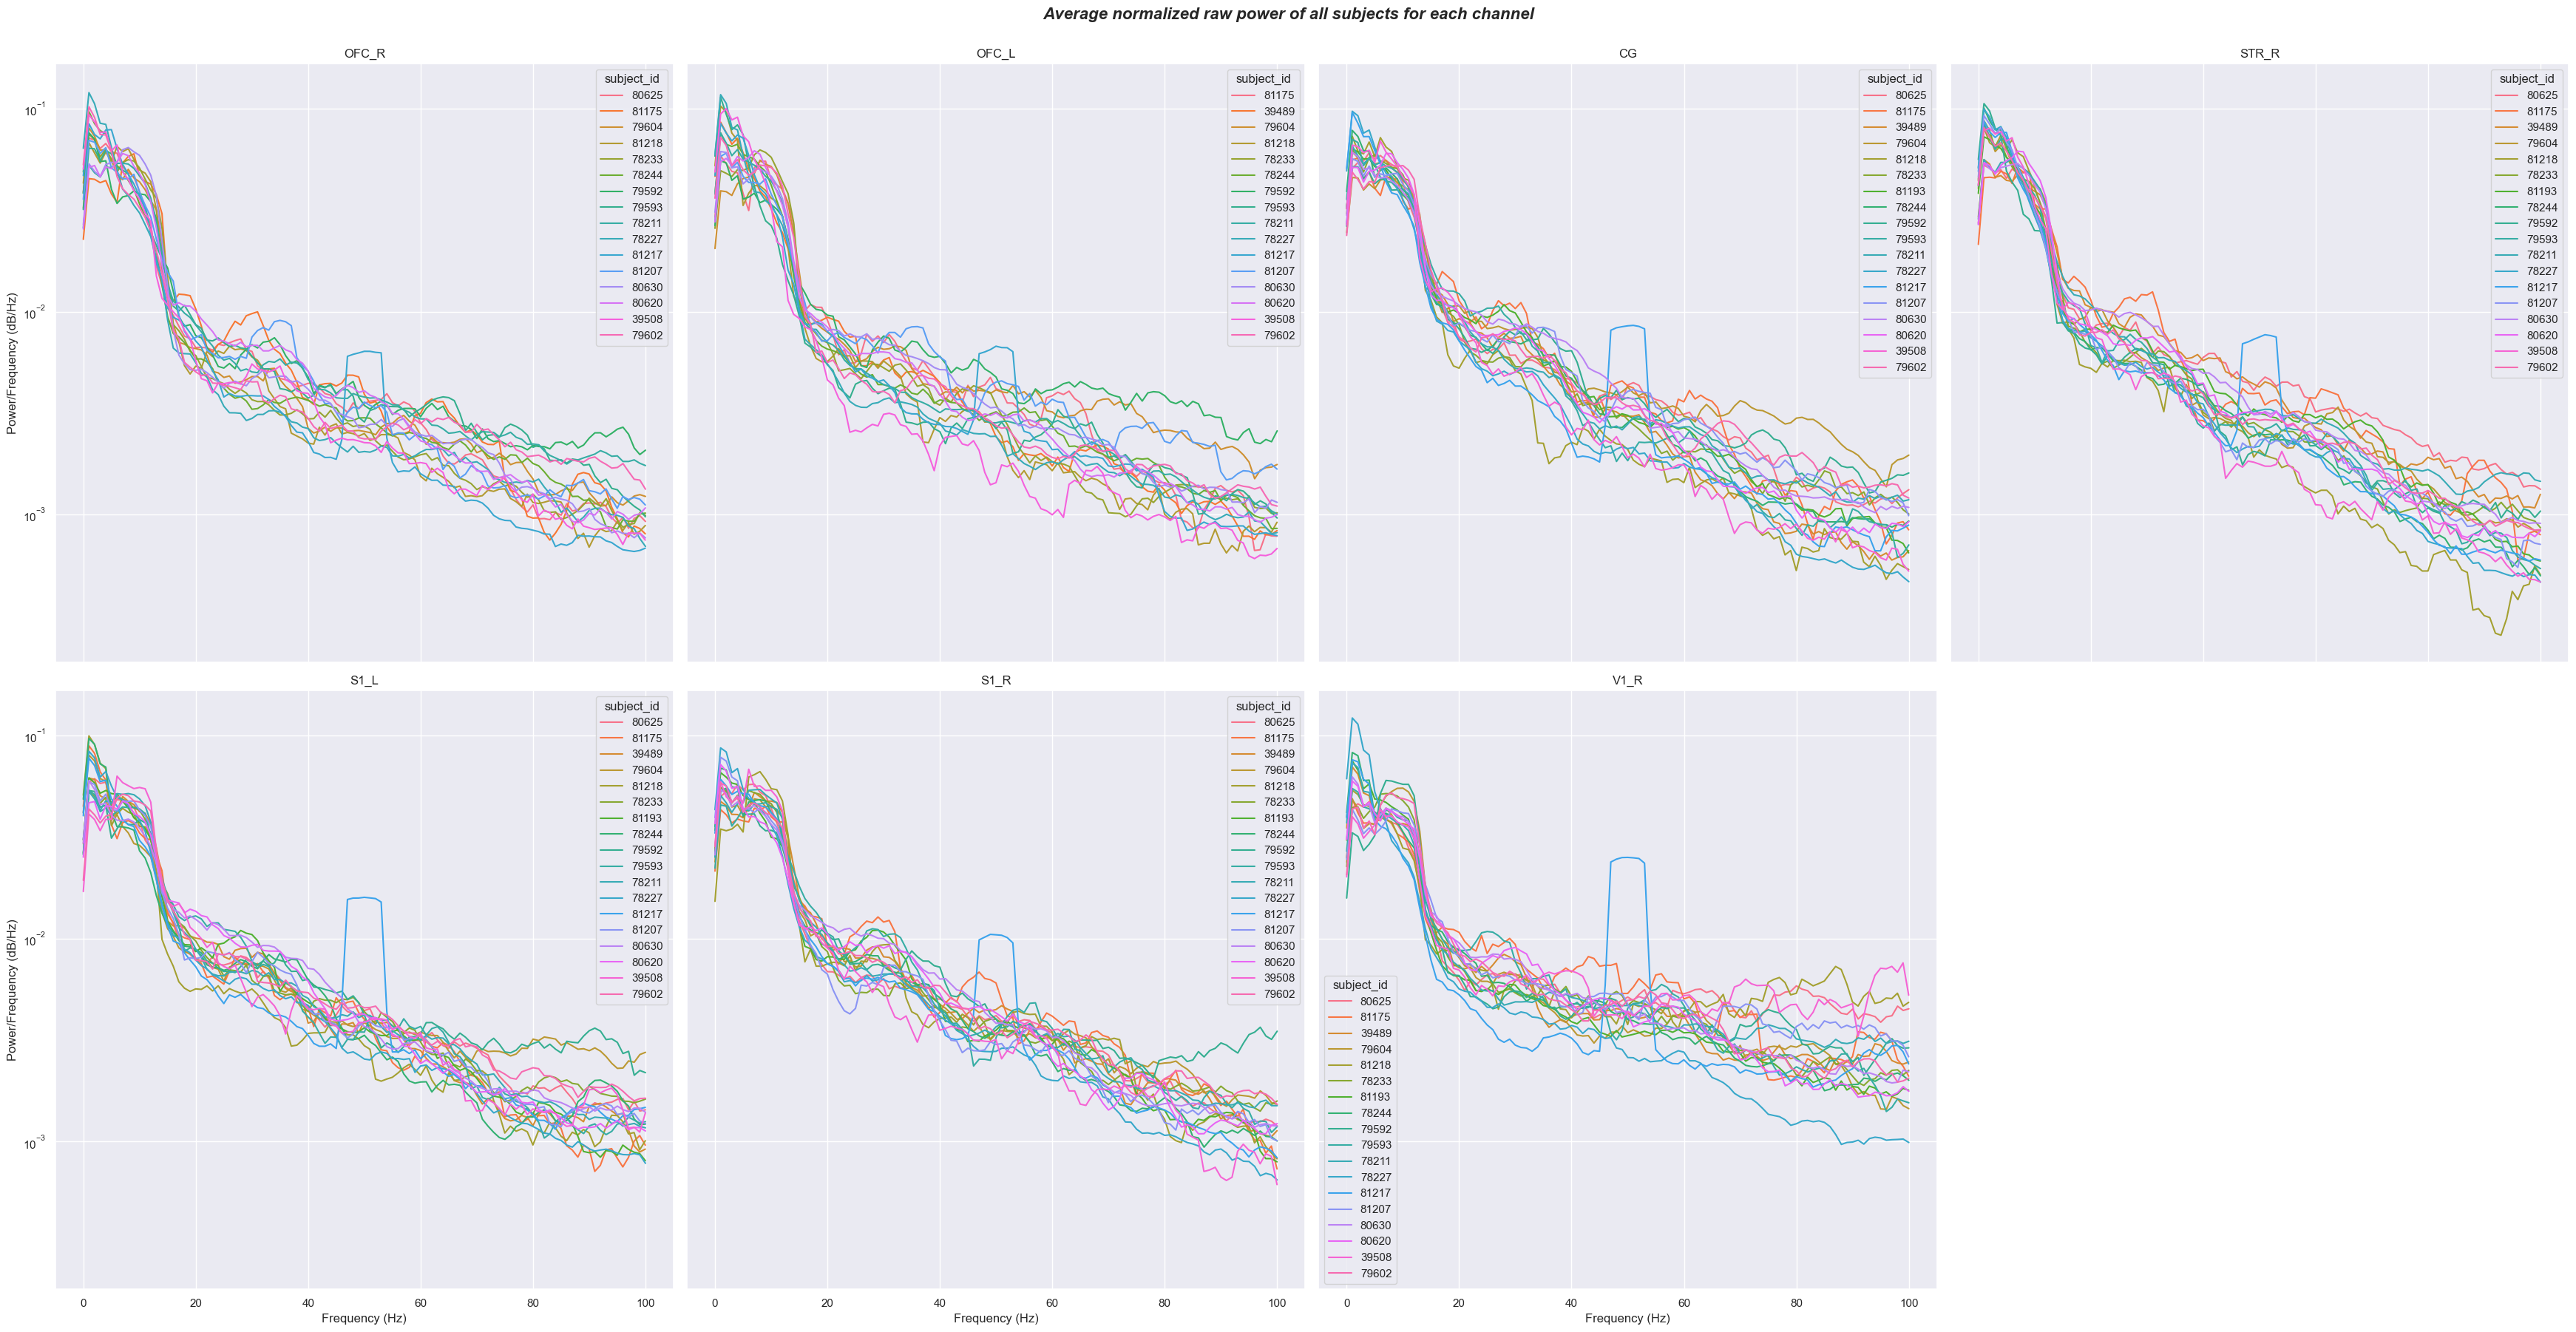

In [18]:
fig, axs = plt.subplots(2, 4, figsize=(35, 18), sharex=True, sharey=True)
axs = axs.ravel()

for i, channel in enumerate(wanted_chans):

    channel_data = df[(df.channel == channel)]

    sns.lineplot(channel_data, y='psd (norm)', x='freq', hue='subject_id', ax=axs[i], errorbar=None)

    axs[i].set_yscale('log')
    axs[i].set_xlabel('Frequency (Hz)')
    axs[i].set_ylabel('Power/Frequency (dB/Hz)')
    axs[i].set_title(channel)

plt.suptitle(
    'Average normalized raw power of all subjects for each channel',
    fontsize=16, fontweight='bold', fontstyle='italic', y=1
)
plt.tight_layout()
axs[-1].remove()
plt.show()

Let's batch all distinct types of epochs (sniff, groom follow) and show the average powers

In [42]:
fig, axs = plt.subplots(2, 4, figsize=(30, 14), sharex=True, sharey=True)
axs = axs.ravel()

for i, channel in enumerate(wanted_chans):

    channel_data = df[df.channel == channel]
    channel_data = channel_data[(channel_data.freq > 51) | (channel_data.freq < 49)]  # remove the 50Hz peak

    sns.lineplot(data=channel_data, x='freq', y='psd (norm)', hue="event_type", legend=True, ax=axs[i], errorbar=('ci', 95))

    for band, (start, end) in freq_bands_eeg.items():
        axs[i].axvline(x=start, color='gray', linestyle='--', alpha=0.3)
        axs[i].axvline(x=end, color='gray', linestyle='--', alpha=0.3)
        axs[i].text((start + end) / 2, axs[i].get_ylim()[1] * 1.01, band, horizontalalignment='center', verticalalignment='top', fontsize=8, color='black')

    axs[i].set_yscale('log')
    axs[i].set_xlabel('Frequency (Hz)')
    axs[i].set_ylabel('Power/Frequency (dB/Hz)')
    axs[i].set_title(channel)

plt.suptitle(
    'Average power over the frequencies for all grooming, sniffing, and follow epochs',
    fontsize=16, fontweight='bold', fontstyle='italic', y=1
)
plt.tight_layout()
axs[-1].remove()
save_figure(os.path.join(plot_folder, f'eeg_power_analysis/average_power_per_event_type.pdf'))

Let's also do this for the to decibel transformed PSD values

In [21]:
fig, axs = plt.subplots(2, 4, figsize=(30, 14), sharex=True, sharey=True)
axs = axs.ravel()

for i, channel in enumerate(wanted_chans):

    channel_data = df[df.channel == channel]
    channel_data = channel_data[(channel_data.freq > 51) | (channel_data.freq < 49)]  # remove the 50Hz peak

    sns.lineplot(data=channel_data, x='freq', y='decibels (norm)', hue="event_type", legend=True, ax=axs[i], errorbar=('ci', 95))

    for band, (start, end) in freq_bands_eeg.items():
        axs[i].axvline(x=start, color='gray', linestyle='--', alpha=0.3)
        axs[i].axvline(x=end, color='gray', linestyle='--', alpha=0.3)
        axs[i].text((start + end) / 2, axs[i].get_ylim()[1] * 1.01, band, horizontalalignment='center', verticalalignment='top', fontsize=8, color='black')

    axs[i].set_xlabel('Frequency (Hz)')
    axs[i].set_ylabel('Decibels (dB)')
    axs[i].set_title(channel)

plt.suptitle(
    'Average power (in decibels) over the frequencies for all grooming, sniffing, and follow epochs',
    fontsize=16, fontweight='bold', fontstyle='italic', y=1
)
plt.tight_layout()
axs[-1].remove()
save_figure(os.path.join(plot_folder, f'eeg_power_analysis/average_power_per_event_type_decibels.pdf'))

### Are there power differences between the genotypes during the distinct events?

Now plot the normalized PSDs per event type and hue also on genotype


KeyboardInterrupt



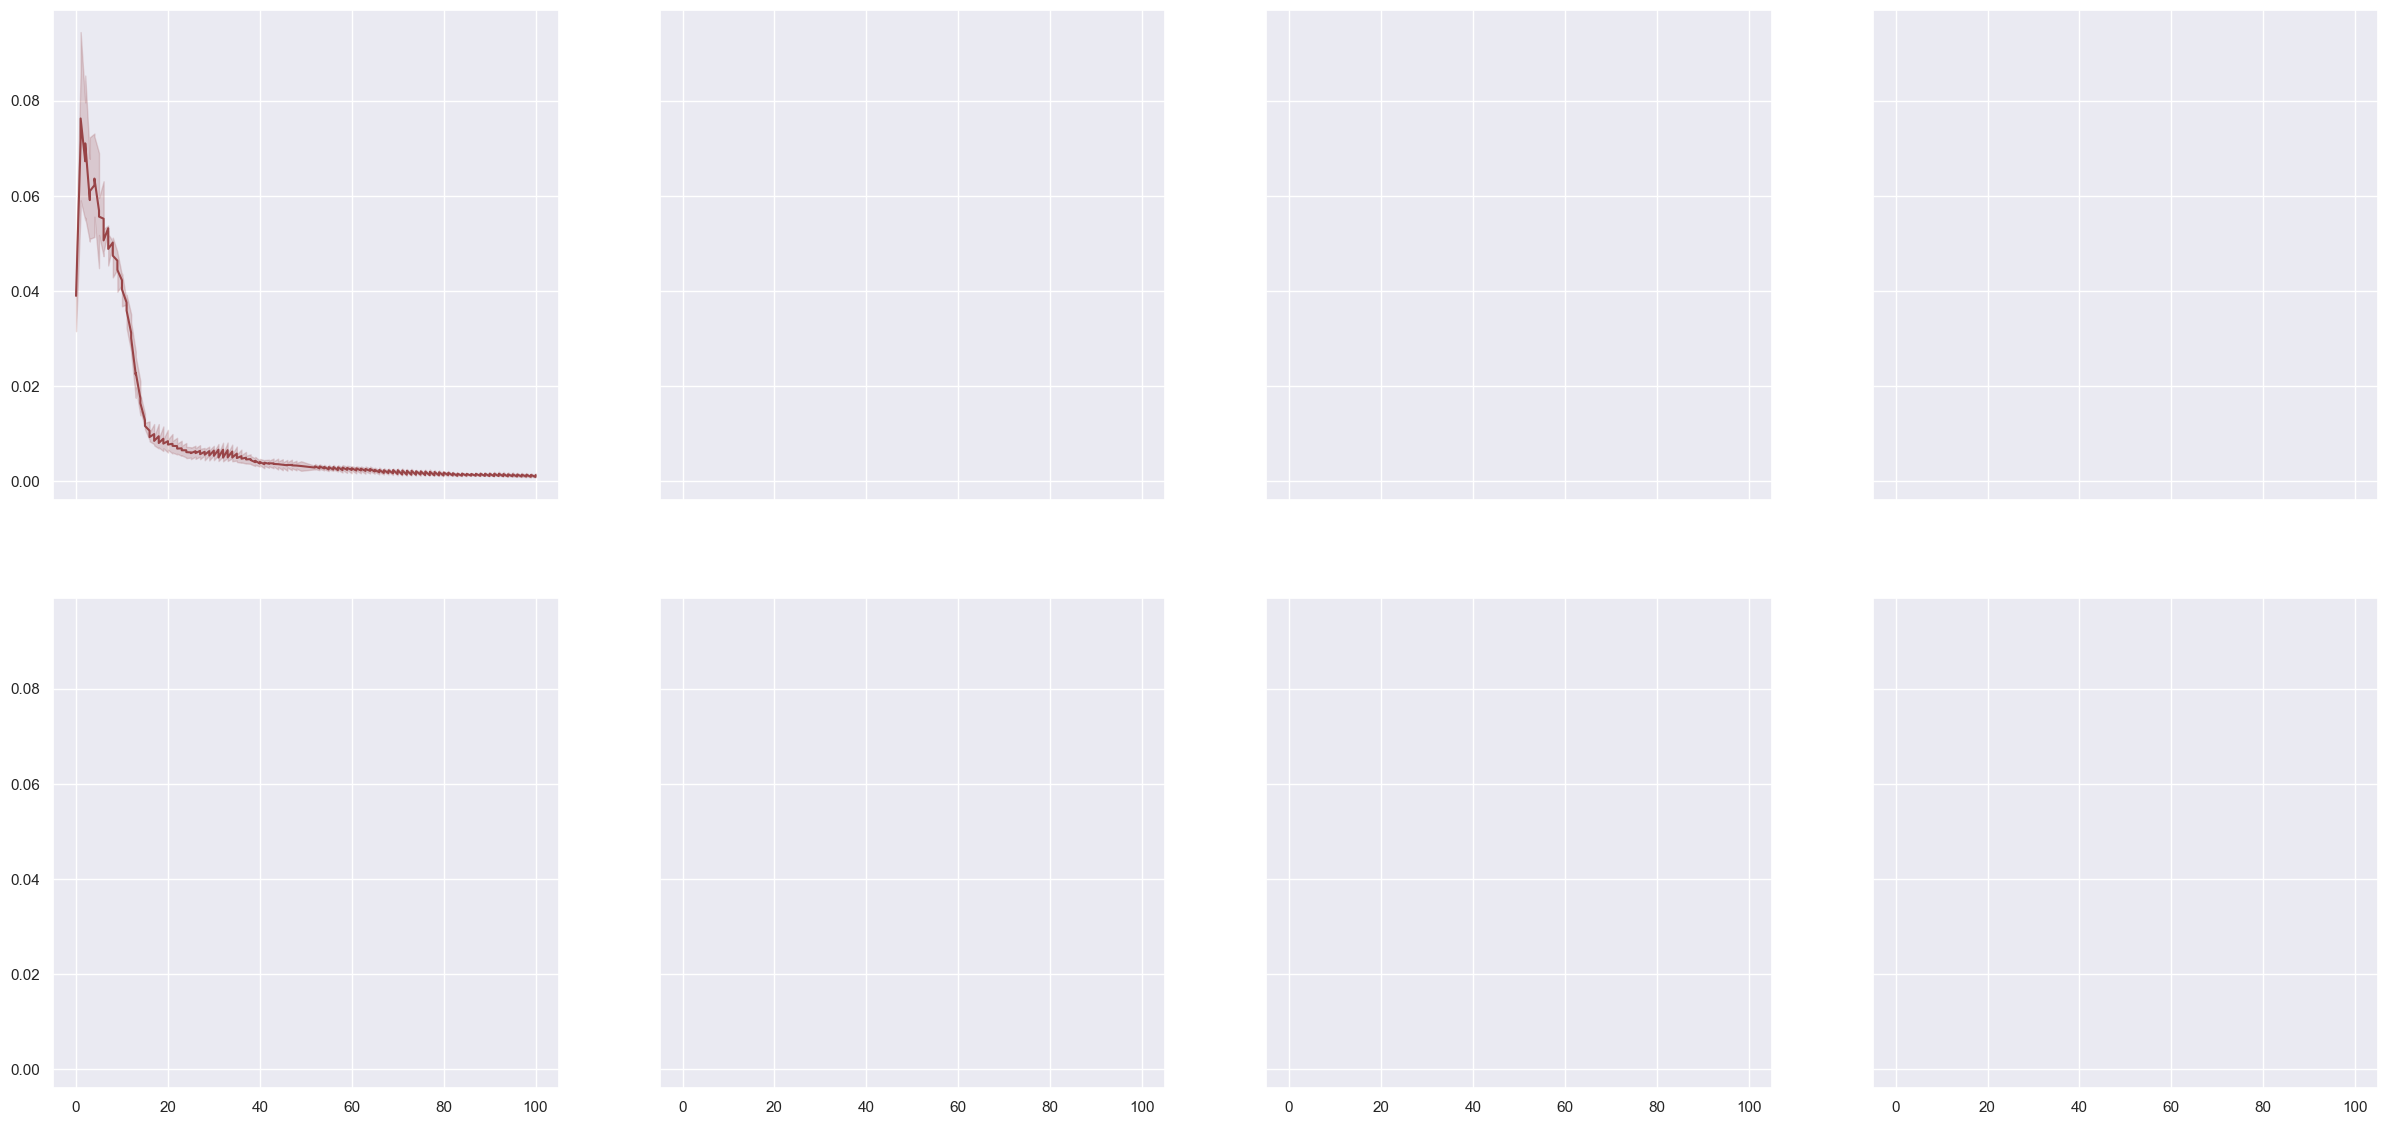

In [23]:
for event_type in df.event_type.unique():
    
    fig, axs = plt.subplots(2, 4, figsize=(30, 14), sharex=True, sharey=True)
    axs = axs.ravel()
    
    event_data = df[df.event_type == event_type]
    
    for i, channel in enumerate(wanted_chans):
        
        channel_data = event_data[event_data.channel == channel]
        channel_data = channel_data[(channel_data.freq > 51) | (channel_data.freq < 49)]  # remove the 50Hz peak
        
        sns.lineplot(data=channel_data, x='freq', y='psd (norm)', hue="genotype", legend=True, ax=axs[i], errorbar=('ci', 95), palette=palette_gr)
        
        for band, (start, end) in freq_bands_eeg.items():
            axs[i].axvline(x=start, color='gray', linestyle='--', alpha=0.3)
            axs[i].axvline(x=end, color='gray', linestyle='--', alpha=0.3)
            axs[i].text((start + end) / 2, axs[i].get_ylim()[1] * 1.01, band, horizontalalignment='center', verticalalignment='top', fontsize=8, color='black')
        
        axs[i].set_yscale('log')
        axs[i].set_xlabel('Frequency (Hz)')
        axs[i].set_ylabel('Power/Frequency (dB/Hz)')
        axs[i].set_title(channel)
        
    plt.suptitle(f'Batched and averaged power of {event_type} events for both DRD2-WT and DRD2-KO genotypes({total_epochs[event_type]} epochs)', fontsize=16, fontweight='bold', fontstyle='italic', y=1)
    plt.tight_layout()
    axs[-1].remove()
    save_figure(os.path.join(plot_folder, f'eeg_power_analysis/average_norm_genotype_powers_{event_type}.pdf'))

Now, instead of batching all WT or KO epochs together per event type and averaging the power, we will average the power of each subject per event type, and then average the WT subjects their powers and the KO subjects their powers

In [24]:
for event_type in df.event_type.unique():

    fig, axs = plt.subplots(2, 4, figsize=(30, 14), sharex=True, sharey=True)
    axs = axs.ravel()

    event_data = df[df.event_type == event_type]
    
    # get the subject's averages for every frequency of each channel 
    subject_averages = event_data.groupby(['subject_id', 'channel', 'freq']).agg({
        'psd (means)': 'mean', 
        'psd (norm)': 'mean',
        'genotype': 'first'
    }).reset_index()

    for i, channel in enumerate(wanted_chans):

        channel_data = subject_averages[subject_averages.channel == channel]
        channel_data = channel_data[(channel_data.freq > 51) | (channel_data.freq < 49)]  # remove the 50Hz peak

        sns.lineplot(data=channel_data, x='freq', y='psd (norm)', hue="genotype", legend=True, ax=axs[i], errorbar=('ci', 95), palette=palette_gr)

        for band, (start, end) in freq_bands_eeg.items():
            axs[i].axvline(x=start, color='gray', linestyle='--', alpha=0.3)
            axs[i].axvline(x=end, color='gray', linestyle='--', alpha=0.3)
            axs[i].text((start + end) / 2, axs[i].get_ylim()[1] * 1.01, band, horizontalalignment='center', verticalalignment='top', fontsize=8, color='black')
        
        axs[i].legend(frameon=False)
        axs[i].set_yscale('log')
        axs[i].set_xlabel('Frequency (Hz)')
        axs[i].set_ylabel('Power/Frequency')
        axs[i].set_title(channel)

    plt.suptitle(f'Average power of {event_type} events for both DRD2-WT and DRD2-KO genotypes ({total_epochs[event_type]} epochs)', fontsize=16, fontweight='bold', fontstyle='italic', y=1)
    plt.tight_layout()
    axs[-1].remove()
    save_figure(os.path.join(plot_folder, f'eeg_power_analysis/average_of_subj_averages_norm_powers_{event_type}.pdf'))

## Batching all social epochs

In [25]:
df_social = df.copy()
df_social.shape

(31512, 9)

In [26]:
df_social = df_social[(df_social['event_type'] == 'sniff') | (df_social['event_type'] == 'follow')]
df_social.shape

(23230, 9)

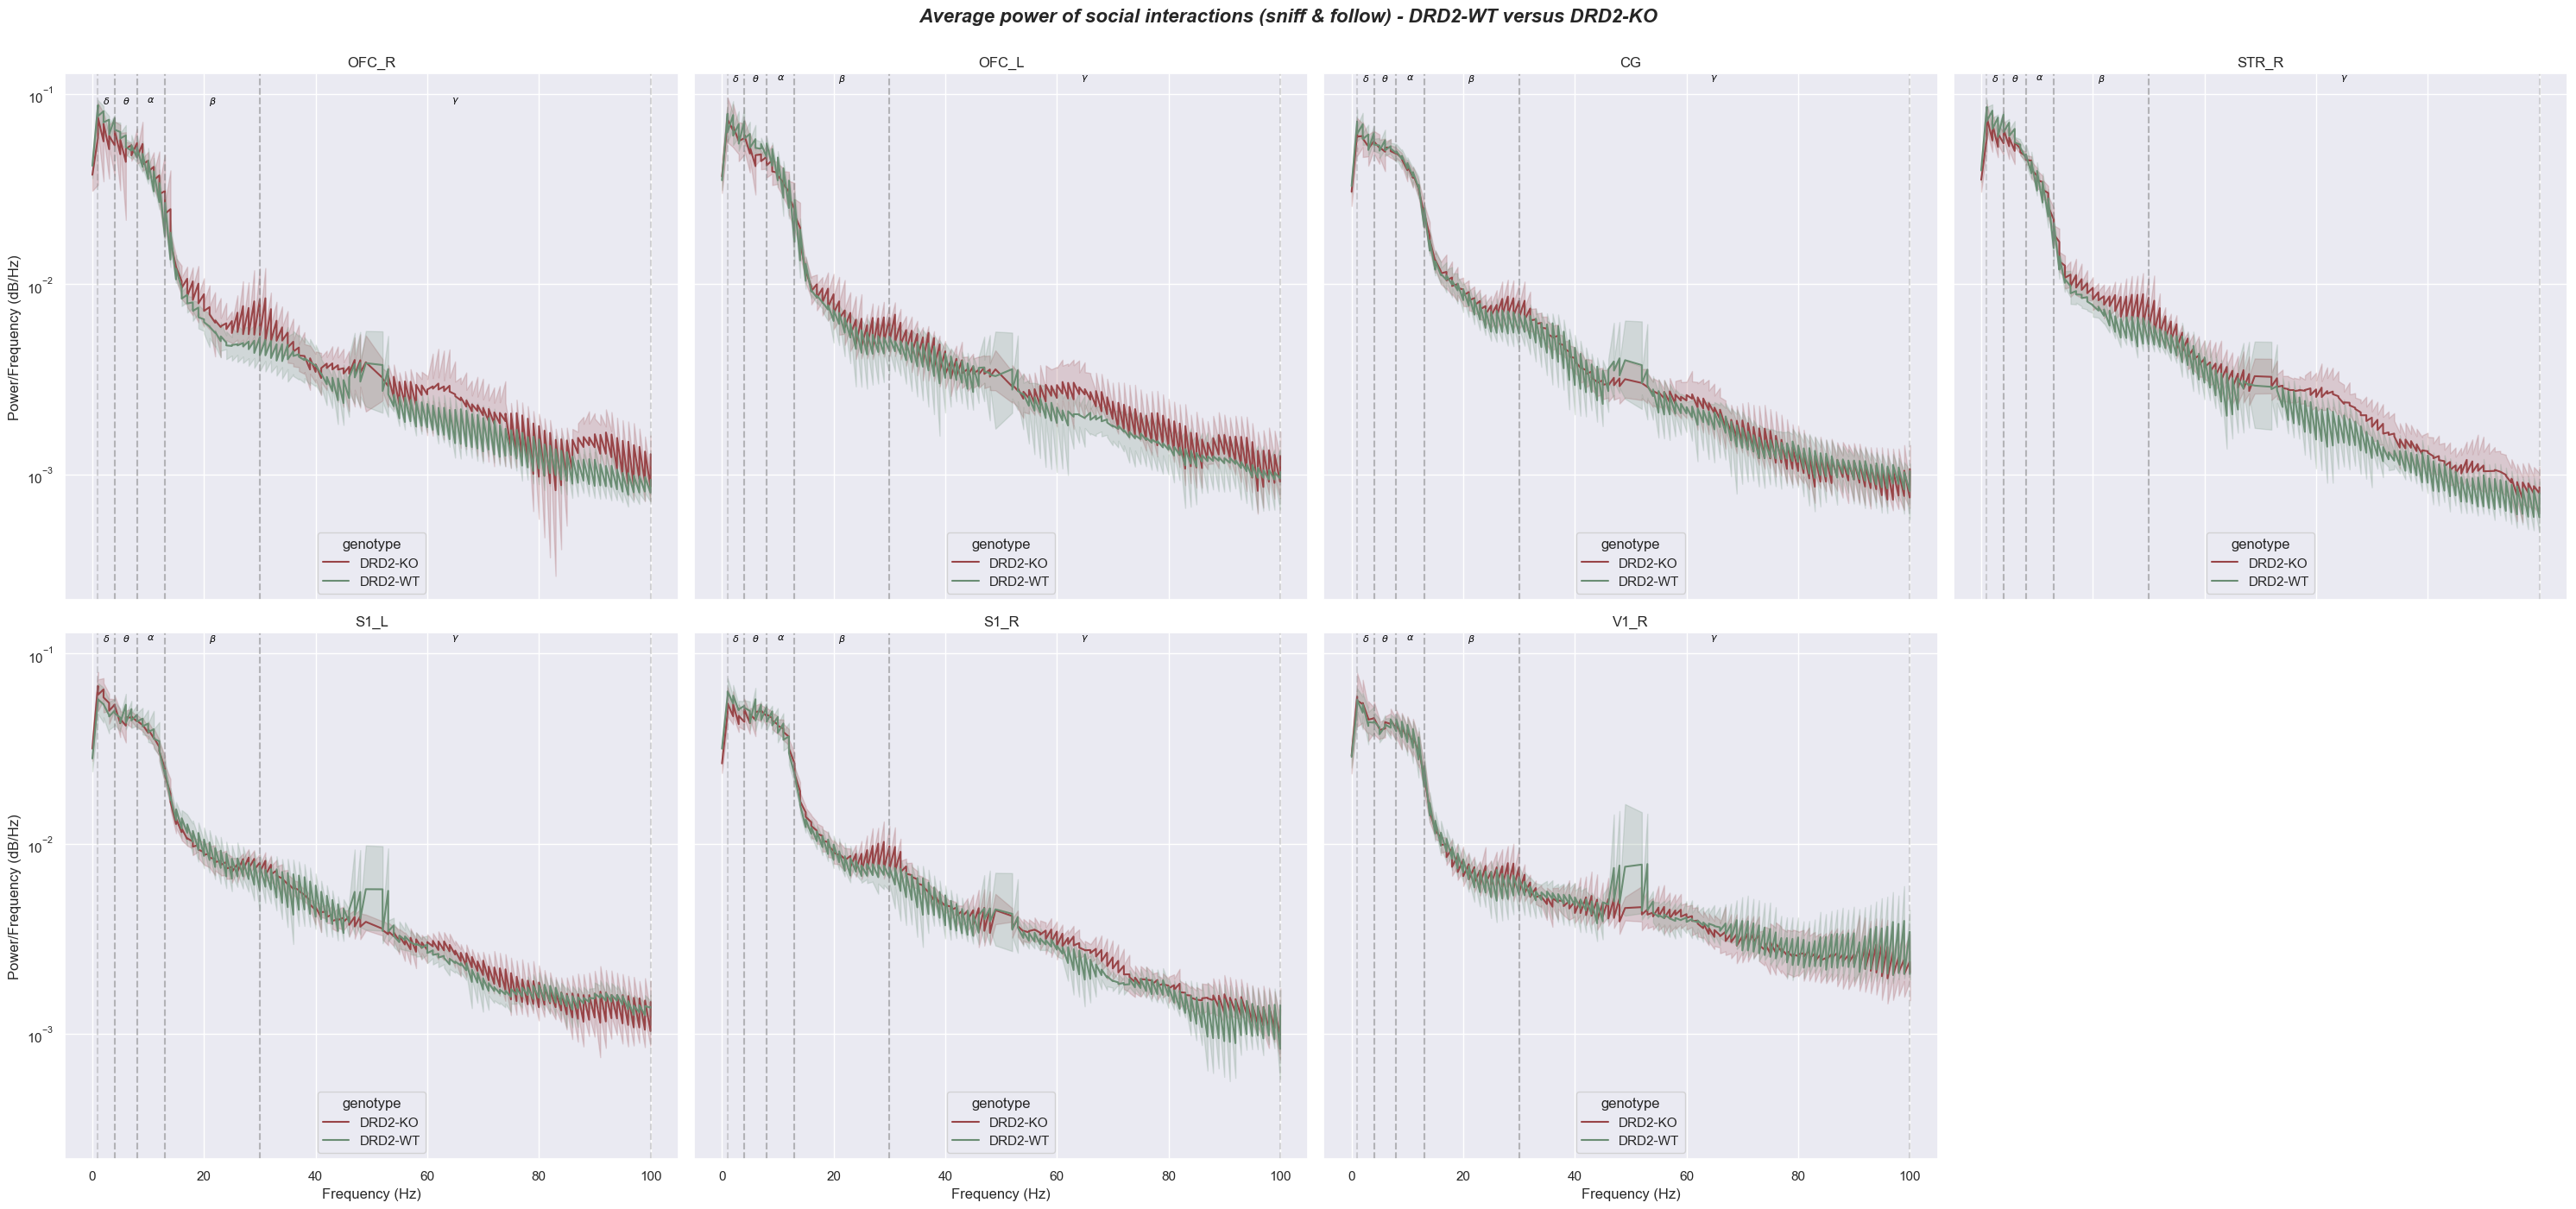

In [27]:
fig, axs = plt.subplots(2, 4, figsize=(30, 14), sharex=True, sharey=True)
axs = axs.ravel()

for i, channel in enumerate(wanted_chans):
    
    channel_data = df_social[df_social.channel == channel]
    channel_data = channel_data[(channel_data.freq > 51) | (channel_data.freq < 49)]  # remove the 50Hz peak
    
    sns.lineplot(data=channel_data, x='freq', y='psd (norm)', hue="genotype", legend=True, ax=axs[i], errorbar=('ci', 95), palette=palette_gr)
    
    for band, (start, end) in freq_bands_eeg.items():
        axs[i].axvline(x=start, color='gray', linestyle='--', alpha=0.3)
        axs[i].axvline(x=end, color='gray', linestyle='--', alpha=0.3)
        axs[i].text((start + end) / 2, axs[i].get_ylim()[1] * 1.01, band, horizontalalignment='center', verticalalignment='top', fontsize=8, color='black')
    
    axs[i].set_yscale('log')
    axs[i].set_xlabel('Frequency (Hz)')
    axs[i].set_ylabel('Power/Frequency (dB/Hz)')
    axs[i].set_title(channel)
    
plt.suptitle(f'Average power of social interactions (sniff & follow) - DRD2-WT versus DRD2-KO', fontsize=16, fontweight='bold', fontstyle='italic', y=1)
plt.tight_layout()
axs[-1].remove()
plt.show()
# save_figure(os.path.join(plot_folder, f'eeg_power_analysis/average_power_social_interactions.pdf'))

## Let's separate the batches on sampling frequency and batch all social epochs again

For this experiment, batches 1, 2, 3, and 4 were recorded at a sampling frequency of 19525 Hz. Batches 5, 5b and 6 were recorded at a sampling frequency of 1084.72 Hz.

In [43]:
df = pd.DataFrame()

for subject_epochs in all_subject_epochs:

    subject_id = subject_epochs.metadata["subject_id"].iloc[0]
    genotype = subject_epochs.metadata["genotype"].iloc[0]

    for event_type in subject_epochs.metadata.event_kind.unique():

        subject_data = subject_epochs[subject_epochs.metadata["event_kind"] == event_type]

        for channel in wanted_chans:
            # skip plotting data of bad quality
            if int(subject_id) in low_qual_chans.keys():
                if channel in low_qual_chans[int(subject_id)]:
                    print(f"Omitting channel {channel} for subject {subject_id}.")
                    continue

            # get the average PSD for this subject
            psds_sub, freqs = psd_array_multitaper(
                subject_data.get_data(picks=channel),
                fmin=0, fmax=100,
                sfreq=subject_data.info['sfreq'],
                n_jobs=-1,
                verbose='WARNING'
            )
            decibels = nanpow2db(psds_sub)

            # normalize the decibels
            total_power = np.abs(np.sum(decibels, axis=-1))
            decibels_norm = decibels / total_power[:, np.newaxis]

            mean_decibels = np.mean(decibels[:, 0, :], axis=0)
            mean_decibels_norm = np.mean(decibels_norm[:, 0, :], axis=0)

            # normalize the raw psds
            total_power = np.sum(psds_sub, axis=-1)
            psds_sub_norm = psds_sub / total_power[:, np.newaxis]

            # average the powers of all epochs
            mean_psd_sub = np.mean(psds_sub[:, 0, :], axis=0)
            mean_psd_sub_norm = np.mean(psds_sub_norm[:, 0, :], axis=0)

            # save the average of this subject, so we can later plot the mean of the subject averages
            df = pd.concat([df, pd.DataFrame({
                "freq": freqs,
                "psd (means)": mean_psd_sub,
                "psd (norm)": mean_psd_sub_norm,
                "decibels": mean_decibels,
                "decibels (norm)": mean_decibels_norm,
                "subject_id": subject_id,
                "genotype": genotype,
                "channel": channel,
                "event_type": event_type,
            })])

    print(f"Done with subject {subject_id}.")

Omitting channel OFC_L for subject 80625.
Omitting channel OFC_L for subject 80625.
Done with subject 80625.
Done with subject 80108.
Done with subject 81175.
Omitting channel OFC_R for subject 39489.
Omitting channel OFC_R for subject 39489.
Done with subject 39489.
Done with subject 79604.
Done with subject 81218.
Done with subject 78233.
Omitting channel OFC_R for subject 81193.
Omitting channel OFC_L for subject 81193.
Omitting channel OFC_R for subject 81193.
Omitting channel OFC_L for subject 81193.
Omitting channel OFC_R for subject 81193.
Omitting channel OFC_L for subject 81193.
Done with subject 81193.
Done with subject 78244.
Done with subject 79592.
Done with subject 79593.
Done with subject 78211.
Done with subject 78227.
Done with subject 81217.
Done with subject 81207.
Done with subject 80630.
Done with subject 80620.
Done with subject 39508.
Done with subject 79602.


In [29]:
df.shape

(32926, 9)

In [30]:
df_social = df[(df['event_type'] == 'sniff') | (df['event_type'] == 'follow')]
df_social.shape

(24644, 9)

In [31]:
ids_high_sf = [str(key) for key, value in subject_id_batch_cage_dict.items() if 'batch1' in value or 'batch2' in value or 'batch3' in value or 'batch4' in value]
ids_low_sf = [str(key) for key, value in subject_id_batch_cage_dict.items() if 'batch5' in value or 'batch5b' in value or 'batch6' in value]
print(ids_high_sf)
print(ids_low_sf)

['78211', '79593', '80620', '80108', '78233', '79592', '80625', '78227', '79604', '80630', '78244', '79602']
['81167', '81217', '39489', '81175', '81218', '39508', '81207', '81193']


In [32]:
df_high_sf = df_social[df_social.subject_id.isin(ids_high_sf)]
df_low_sf = df_social[df_social.subject_id.isin(ids_low_sf)]

Let's inspect

In [33]:
df_high_sf.head()

freq  psd (means)  psd (norm)   decibels  decibels (norm) subject_id  \
0   0.0     0.000003    0.038603 -57.189873        -0.008492      80625   
1   1.0     0.000005    0.070308 -54.642952        -0.008114      80625   
2   2.0     0.000005    0.074070 -54.229040        -0.008053      80625   
3   3.0     0.000004    0.060204 -54.915967        -0.008155      80625   
4   4.0     0.000004    0.061610 -54.674243        -0.008118      80625   

  genotype channel event_type  
0  DRD2-KO   OFC_R      sniff  
1  DRD2-KO   OFC_R      sniff  
2  DRD2-KO   OFC_R      sniff  
3  DRD2-KO   OFC_R      sniff  
4  DRD2-KO   OFC_R      sniff

In [34]:
df_low_sf.head()

freq   psd (means)  psd (norm)   decibels  decibels (norm) subject_id  \
0  0.000000  8.198260e-08    0.028279 -71.686714        -0.008898      81175   
1  0.999741  1.645078e-07    0.057028 -68.644638        -0.008521      81175   
2  1.999482  1.579762e-07    0.054891 -68.779138        -0.008538      81175   
3  2.999223  1.470831e-07    0.050389 -69.005122        -0.008566      81175   
4  3.998964  1.495362e-07    0.051347 -68.832879        -0.008545      81175   

  genotype channel event_type  
0  DRD2-KO   OFC_R      sniff  
1  DRD2-KO   OFC_R      sniff  
2  DRD2-KO   OFC_R      sniff  
3  DRD2-KO   OFC_R      sniff  
4  DRD2-KO   OFC_R      sniff

And now remove the unwanted subject(s) again

In [45]:
df_high_sf = df_high_sf[~df_high_sf.subject_id.isin(['80108'])]
df_high_sf.subject_id.unique()

array(['80625', '79604', '78233', '78244', '79592', '79593', '78211',
       '78227', '80630', '80620', '79602'], dtype=object)

### High sampling frequency batches

How many of each genotype in the high frequency batches?

In [46]:
np.unique(df_high_sf[(df_high_sf.freq == 1.0) & (df_high_sf.channel == 'OFC_R') & (df_high_sf.event_type == 'sniff')].genotype, return_counts=True)

(array(['DRD2-KO', 'DRD2-WT'], dtype=object), array([6, 5]))

So, there are 6 KOs and 6 WTs in the first 4 batches. Let's plot the difference in social epoch power between the two genotypes again.

In [47]:
fig, axs = plt.subplots(2, 4, figsize=(30, 14), sharex=True, sharey=True)
axs = axs.ravel()

for i, channel in enumerate(wanted_chans):
    
    channel_data = df_high_sf[df_high_sf.channel == channel]
    channel_data = channel_data[(channel_data.freq > 51) | (channel_data.freq < 49)]  # remove the 50Hz peak
    
    sns.lineplot(data=channel_data, x='freq', y='psd (norm)', hue="genotype", legend=True, ax=axs[i], errorbar=('ci', 95), palette=palette_gr)
    
    for band, (start, end) in freq_bands_eeg.items():
        axs[i].axvline(x=start, color='gray', linestyle='--', alpha=0.3)
        axs[i].axvline(x=end, color='gray', linestyle='--', alpha=0.3)
        axs[i].text((start + end) / 2, axs[i].get_ylim()[1] * 1.01, band, horizontalalignment='center', verticalalignment='top', fontsize=8, color='black')
    
    axs[i].set_yscale('log')
    axs[i].set_xlabel('Frequency (Hz)')
    axs[i].set_ylabel('Power/Frequency (dB/Hz)')
    axs[i].set_title(channel)
    
plt.suptitle(f'Average power of social interactions (sniff & follow) - DRD2-WT versus DRD2-KO - High sampling frequency batches (n WT = 6, n KO = 6)', fontsize=16, fontweight='bold', fontstyle='italic', y=1)
plt.tight_layout()
axs[-1].remove()
save_figure(os.path.join(plot_folder, f'eeg_power_analysis/average_power_social_interactions_batches_1-4.pdf'))

There seems to be something going on here in the higher frequencies (beta and gamma).

### Low sampling frequency batches

Now, let's do the same for the low sampling frequency batches.

How many of each genotype in the lower frequency batches?

In [37]:
np.unique(df_low_sf[(df_low_sf.freq == 1.0) & (df_low_sf.channel == 'STR_R') & (df_low_sf.event_type == 'sniff')].genotype, return_counts=True)

(array([], dtype=object), array([], dtype=int64))

In [38]:
fig, axs = plt.subplots(2, 4, figsize=(30, 14), sharex=True, sharey=True)
axs = axs.ravel()

for i, channel in enumerate(wanted_chans):
    
    channel_data = df_low_sf[df_low_sf.channel == channel]
    channel_data = channel_data[(channel_data.freq > 51) | (channel_data.freq < 49)]  # remove the 50Hz peak
    
    sns.lineplot(data=channel_data, x='freq', y='psd (norm)', hue="genotype", legend=True, ax=axs[i], errorbar=('ci', 95), palette=palette_gr)
    
    for band, (start, end) in freq_bands_eeg.items():
        axs[i].axvline(x=start, color='gray', linestyle='--', alpha=0.3)
        axs[i].axvline(x=end, color='gray', linestyle='--', alpha=0.3)
        axs[i].text((start + end) / 2, axs[i].get_ylim()[1] * 1.01, band, horizontalalignment='center', verticalalignment='top', fontsize=8, color='black')
    
    axs[i].set_yscale('log')
    axs[i].set_xlabel('Frequency (Hz)')
    axs[i].set_ylabel('Power/Frequency (dB/Hz)')
    axs[i].set_title(channel)
    
plt.suptitle(f'Average power of social interactions (sniff & follow) - DRD2-WT versus DRD2-KO - Low sampling frequency batches', fontsize=16, fontweight='bold', fontstyle='italic', y=1)
plt.tight_layout()
axs[-1].remove()
save_figure(os.path.join(plot_folder, f'eeg_power_analysis/average_power_social_interactions_batches_5-6.pdf'))

This looks way too sketchy to get anything out of.